In [1]:
import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
import numpy as np

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
def logit(p):
    return np.log(p) - np.log(1 - p)


In [3]:
time = np.linspace(0,100,100)
y = np.sin(2*np.pi*time) + np.random.normal(0, .05, size=time.size)
y[97:] = None
y[10:12] = None




with pm.Model() as model:
    σ_ϵ = pm.HalfNormal('σ_ϵ', 1)
    alpha = pm.Uniform('alpha', 0,1)
    nu_0 = pm.Gamma('nu_0', alpha=2, beta=0.1)
    μ = pm.GaussianRandomWalk('μ',
                              sigma=σ_ϵ * (1.0 - alpha),
                              shape=len(y))

    level = pm.StudentT('level',
                      mu=μ,
                        nu=nu_0,
                      sigma=σ_ϵ * alpha,
                      observed=y
                    )

    trace = pm.sample(2000,
                      tune=3000,
                      target_accept=.95,
                      return_inferencedata=True)


    ppc = pm.sample_posterior_predictive(trace)

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in level contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [level_missing, μ, nu_0, alpha, σ_ϵ]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 84 seconds.
The acceptance probability does not

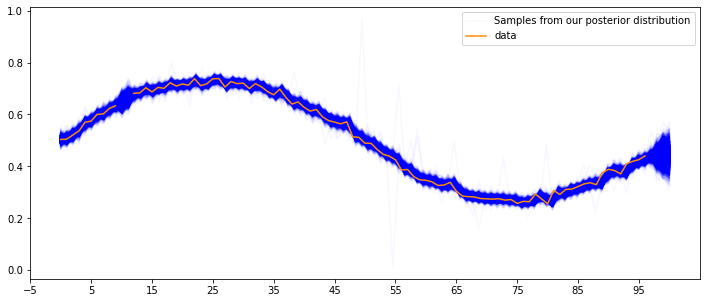

In [4]:
with model:
    _, ax = plt.subplots(1,1,figsize=(12,5))
    predictions = inv_logit(ppc['level'])
    ax.plot(time, predictions.T[:,1:], alpha=0.03, color='b', label='_')
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 10))


    ax.plot(time,predictions.T[:,1],alpha=0.03, color='b', label='Samples from our posterior distribution')
    ax.plot(inv_logit(y), color='darkorange', label='data')
    ax.legend()
    az.summary(trace)

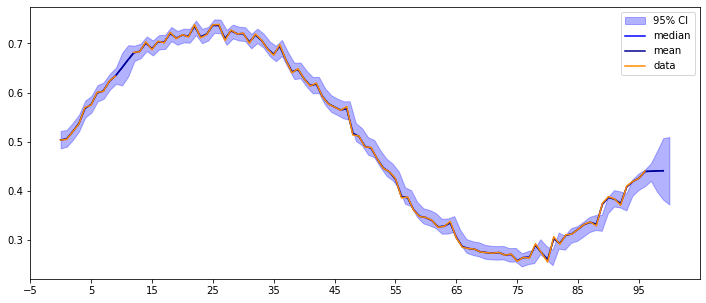

In [5]:

predictions = inv_logit(ppc['level'])
CI = np.percentile(predictions, axis=0, q=[2.5, 50, 97.5])

mean = np.mean(predictions, axis=0)

_, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(time,CI[0], CI[2] ,alpha=0.3, color='b', label='95% CI')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
ax.plot(CI[1], color='b', label='median')
ax.plot(mean, color='darkblue', label='mean')
ax.plot(inv_logit(y), color='darkorange', label='data')
ax.legend();

In [6]:
y

array([ 0.01414344,  0.01981899,  0.08336087,  0.14553088,  0.28110209,
        0.30035894,  0.40824637,  0.41484703,  0.50361615,  0.54734003,
               nan,         nan,  0.7615346 ,  0.76869751,  0.86310862,
        0.78707527,  0.86862552,  0.85253586,  0.95705617,  0.89391247,
        0.93310768,  0.91017931,  1.03628237,  0.90254684,  0.93404238,
        1.03472718,  1.03859586,  0.8760811 ,  0.98086313,  0.93938177,
        0.94971113,  0.84829703,  0.94015787,  0.87964167,  0.79203502,
        0.7352738 ,  0.83701104,  0.69074839,  0.57592307,  0.61236662,
        0.52284728,  0.46101341,  0.48745681,  0.37056178,  0.30892061,
        0.28428207,  0.25761544,  0.28882236,  0.05544555,  0.04686874,
       -0.04229128, -0.04554582, -0.13982039, -0.21602882, -0.24355212,
       -0.30029349, -0.46447714, -0.45617151, -0.57271191, -0.62886374,
       -0.63561125, -0.66151975, -0.72551273, -0.71700903, -0.67068205,
       -0.82506278, -0.91761251, -0.92914061, -0.93539603, -0.96

In [157]:
days = np.arange(80)
h = .75
fundamental=.6
state_polls = np.clip(np.random.normal(h+.01, .01, size=days.size), a_min=0.01, a_max=.99)
national_polls = np.clip(np.random.normal((h-.01)- np.exp(-np.arange(80)/10), .03, size=days.size), a_min=0.01, a_max=.99)
state_observed = logit(state_polls)
state_observed[::5] = None
state_observed[1::5] = None
state_observed[2::5] = None
state_observed[3::5] = None
state_observed[-10:] = None
national_observed = logit(national_polls)-state_observed
national_observed[::10] = None
national_observed[1::10] = None
national_observed[2::10] = None
national_observed[3::10] = None
national_observed[-20:] = None
# national_observed = np.zeros_like(days)

In [188]:

with pm.Model() as linzer_model:
    σ_δ = pm.HalfNormal('σ_δ', .01)
    σ_β = pm.HalfNormal('σ_β', .01)
    # τ = pm.Constant('tau', c=20)
    τ = pm.Uniform('τ', lower=10,upper=20)  # This is up to the discretion of the analyst
    # β_J = pm.Normal('β_J', mu=pm.logit(h), tau=τ)
    fundamental_dist = pm.Normal('f', mu=pm.logit(fundamental), sigma=.1)
    β_J = pm.Normal.dist(mu=fundamental_dist, tau=τ)
    μ_β = pm.GaussianRandomWalk('μ_β',
                                sigma=σ_β,
                                init=β_J,
                                shape=len(days)
                                )
    μ_δ = pm.GaussianRandomWalk('μ_δ',
                                sigma=σ_δ,
                                shape=len(days)
                                )
    β = pm.Normal('β', mu=μ_β, sigma=σ_β, observed=state_observed[::-1])
    δ = pm.Normal('δ', mu=μ_δ, sigma=σ_δ, observed=national_observed[::-1])
    π = pm.Deterministic('π', pm.invlogit(β + δ))
    # y_k = pm.Binomial('y_k', p=π[-1], n=1000)

    trace = pm.sample(1000,
                      # tune=3000,
                      return_inferencedata=True)
    ppc = pm.sample_posterior_predictive(trace)

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in β contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in δ contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [δ_missing, β_missing, μ_δ, μ_β, f, τ, σ_β, σ_δ]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda ins

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
The number of effective samples is s

In [137]:
ppc

{'β': array([[0.95397383, 1.03690779, 1.01865343, ..., 1.21027441, 1.27910028,
         1.29947531],
        [1.16090652, 1.09234707, 1.12681387, ..., 1.19276336, 1.19349062,
         1.07919401],
        [0.99033606, 1.06313621, 1.07233952, ..., 1.19263857, 1.25595534,
         1.33542466],
        ...,
        [0.98297999, 1.03526282, 1.09395252, ..., 1.19849678, 1.18444318,
         1.20433099],
        [1.09513934, 1.12984373, 1.10177191, ..., 1.08285053, 1.0632339 ,
         1.04124873],
        [1.03664236, 1.03571961, 1.00709312, ..., 1.11235473, 1.09204432,
         1.13015843]]),
 'δ': array([[-3.09413573, -2.74482858, -2.94544294, ...,  1.06652829,
          0.92836362,  1.16126887],
        [-2.34025718, -2.1509951 , -2.48839121, ...,  2.00863333,
          1.58344362,  1.8686055 ],
        [-2.59368381, -3.04659867, -2.75390236, ...,  0.67238467,
          0.67403529,  0.36646778],
        ...,
        [-3.23696888, -2.42872488, -2.0412551 , ...,  1.25999953,
          1.63

In [161]:
inv_logit((ppc['β']+ppc['δ']))[:5]

array([[0.33820926, 0.44684123, 0.22447833, 0.28859406, 0.43881371,
        0.21015412, 0.26714979, 0.27950885, 0.08695416, 0.27537898,
        0.35616784, 0.42677922, 0.39778387, 0.40017245, 0.44015357,
        0.73995209, 0.61521313, 0.70321607, 0.50325714, 0.52052378,
        0.75164114, 0.53176783, 0.62395536, 0.50842662, 0.86893128,
        0.78855147, 0.74282685, 0.67316433, 0.65884274, 0.75818323,
        0.69542782, 0.71424145, 0.77799865, 0.76356814, 0.82083932,
        0.81924094, 0.81045737, 0.81801606, 0.83054962, 0.71785581,
        0.63280072, 0.71532991, 0.83574845, 0.80240283, 0.72662531,
        0.80830492, 0.81239716, 0.74927187, 0.74598264, 0.62045642,
        0.82204904, 0.61697868, 0.80246666, 0.87114508, 0.89592889,
        0.77378174, 0.7276617 , 0.70969972, 0.36445708, 0.57720376,
        0.49453788, 0.48639727, 0.33945062, 0.28835611, 0.69014671,
        0.58411622, 0.4276149 , 0.36342247, 0.43879938, 0.40682143,
        0.41818607, 0.35442192, 0.28543527, 0.23

In [153]:
inv_logit(ppc['β'])[:5]

array([[0.73385064, 0.75593203, 0.74048933, 0.73654476, 0.74610112,
        0.75221383, 0.7413134 , 0.76386854, 0.77482361, 0.75976405,
        0.74291114, 0.75518484, 0.76353029, 0.75974439, 0.76457578,
        0.7418467 , 0.76120914, 0.7406937 , 0.760962  , 0.74054316,
        0.73523507, 0.75540048, 0.7682614 , 0.79207838, 0.78755069,
        0.78330302, 0.77061923, 0.77858449, 0.77685697, 0.75458973,
        0.75175381, 0.73648418, 0.73028418, 0.74303894, 0.74847327,
        0.74760811, 0.74974358, 0.74202824, 0.74664432, 0.76968227,
        0.74735275, 0.73733632, 0.73879507, 0.75523324, 0.74945246,
        0.7486545 , 0.74788111, 0.76648249, 0.74177287, 0.75758089,
        0.76887232, 0.7538304 , 0.74471617, 0.74178014, 0.76544785,
        0.74804482, 0.74341543, 0.73776557, 0.7543481 , 0.75473481,
        0.76523852, 0.76146949, 0.79831168, 0.7864703 , 0.76455421,
        0.77904421, 0.77756595, 0.77820701, 0.7962983 , 0.80157939,
        0.76255814, 0.76636178, 0.76993093, 0.76

In [152]:
national_polls

array([0.01      , 0.01      , 0.01      , 0.032792  , 0.02778422,
       0.18335004, 0.19154985, 0.21667391, 0.26654156, 0.35996764,
       0.38569362, 0.41477667, 0.44459068, 0.46437274, 0.49404821,
       0.51389619, 0.48416548, 0.61275209, 0.59643327, 0.51875667,
       0.61322505, 0.63649952, 0.65363619, 0.68262761, 0.65088085,
       0.69824744, 0.6824232 , 0.67715224, 0.69397767, 0.64824351,
       0.72154009, 0.66110331, 0.69077965, 0.69355775, 0.71911903,
       0.70052246, 0.69468178, 0.73151106, 0.76261585, 0.78944961,
       0.69974943, 0.74305271, 0.74898797, 0.76250961, 0.73894861,
       0.69563811, 0.72466223, 0.72092156, 0.78153114, 0.7554022 ,
       0.72716969, 0.74592598, 0.7192853 , 0.80257723, 0.76022005,
       0.75943483, 0.74717171, 0.7584891 , 0.76300611, 0.7790752 ,
       0.73887591, 0.76364437, 0.73008487, 0.69299746, 0.73889975,
       0.69733036, 0.77085422, 0.77107258, 0.68751587, 0.74585334,
       0.71739887, 0.77426301, 0.77953255, 0.7122962 , 0.77411

In [116]:
inv_logit(ppc['δ'])[:5]

array([[0.07229626, 0.05675173, 0.07454559, 0.07709125, 0.09786706,
        0.14878574, 0.16638511, 0.30397872, 0.2478176 , 0.37675542,
        0.38463034, 0.40493821, 0.40397736, 0.43799887, 0.40769801,
        0.51913325, 0.55552849, 0.57334807, 0.57349787, 0.51631699,
        0.49437737, 0.58243277, 0.57409061, 0.6532327 , 0.62241533,
        0.59563417, 0.70761099, 0.71444622, 0.66747712, 0.66834236,
        0.61165561, 0.70379826, 0.62701904, 0.72257448, 0.73162749,
        0.73442579, 0.68502783, 0.72961164, 0.79539144, 0.79407636,
        0.79133041, 0.8122522 , 0.80029787, 0.72468344, 0.72075499,
        0.78962373, 0.80434887, 0.75269828, 0.64568726, 0.6734462 ,
        0.71575191, 0.81031555, 0.83140195, 0.78462238, 0.8084505 ,
        0.7726613 , 0.75600846, 0.737937  , 0.7754015 , 0.75721683,
        0.79971684, 0.77200692, 0.73906196, 0.77547977, 0.71921356,
        0.80193643, 0.70215867, 0.74354071, 0.75811848, 0.69034322,
        0.74268907, 0.74688023, 0.80280467, 0.75

array([[0.07073758, 0.06215626, 0.07202673, ..., 0.22447833, 0.44684123,
        0.33820926],
       [0.13704221, 0.14077148, 0.09379848, ..., 0.17691951, 0.24270774,
        0.17826507],
       [0.01744003, 0.02489382, 0.04102562, ..., 0.99550219, 0.99263219,
        0.98958387],
       ...,
       [0.07130933, 0.1055324 , 0.09831918, ..., 0.77541676, 0.7573079 ,
        0.78660545],
       [0.14883747, 0.10814456, 0.08152217, ..., 0.8466145 , 0.84530436,
        0.78489143],
       [0.03981866, 0.05346317, 0.02957644, ..., 0.83580793, 0.88150356,
        0.89247502]])

[[0.06096965 0.06713866 0.08728502 ... 0.81920603 0.81252052 0.78593181]
 [0.07035432 0.06868785 0.08179517 ... 0.84193634 0.87470015 0.87062764]
 [0.08014599 0.06999588 0.07391831 ... 0.87056312 0.84795146 0.82408754]
 ...
 [0.07837763 0.0650153  0.05895001 ... 0.7968413  0.81456746 0.81427764]
 [0.0498871  0.05250666 0.07257535 ... 0.58262183 0.63636676 0.68358757]
 [0.05183423 0.05985695 0.0720419  ... 0.61122589 0.62606661 0.67589975]]


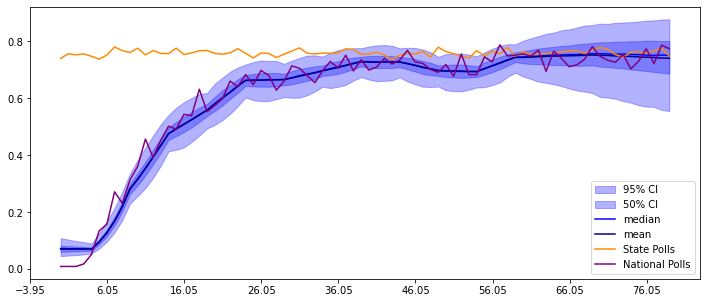

In [189]:
predictions = inv_logit(ppc['β']+ppc['δ'])[:,::-1]
print(predictions)
CI = np.percentile(predictions, axis=0, q=[2.5, 50, 97.5])
CI50 = np.percentile(predictions,axis=0, q=[25,50,75])

mean = np.mean(predictions, axis=0)

_, ax = plt.subplots(1, 1, figsize=(12,5))
ax.fill_between(days, CI[0], CI[2] ,alpha=0.3, color='b', label='95% CI')
ax.fill_between(days, CI50[0], CI50[2] ,alpha=0.3, color='b', label='50% CI')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
ax.plot(CI[1], color='b', label='median')
ax.plot(mean, color='darkblue', label='mean')
ax.plot(state_polls, color='darkorange', label='State Polls')
ax.plot(national_polls, color='purple', label='National Polls')
ax.legend()

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have

array([[<AxesSubplot:title={'center':'μ_β'}>,
        <AxesSubplot:title={'center':'μ_β'}>],
       [<AxesSubplot:title={'center':'μ_δ'}>,
        <AxesSubplot:title={'center':'μ_δ'}>],
       [<AxesSubplot:title={'center':'β_missing'}>,
        <AxesSubplot:title={'center':'β_missing'}>],
       [<AxesSubplot:title={'center':'δ_missing'}>,
        <AxesSubplot:title={'center':'δ_missing'}>],
       [<AxesSubplot:title={'center':'σ_δ'}>,
        <AxesSubplot:title={'center':'σ_δ'}>],
       [<AxesSubplot:title={'center':'σ_β'}>,
        <AxesSubplot:title={'center':'σ_β'}>],
       [<AxesSubplot:title={'center':'τ'}>,
        <AxesSubplot:title={'center':'τ'}>],
       [<AxesSubplot:title={'center':'π'}>,
        <AxesSubplot:title={'center':'π'}>]], dtype=object)

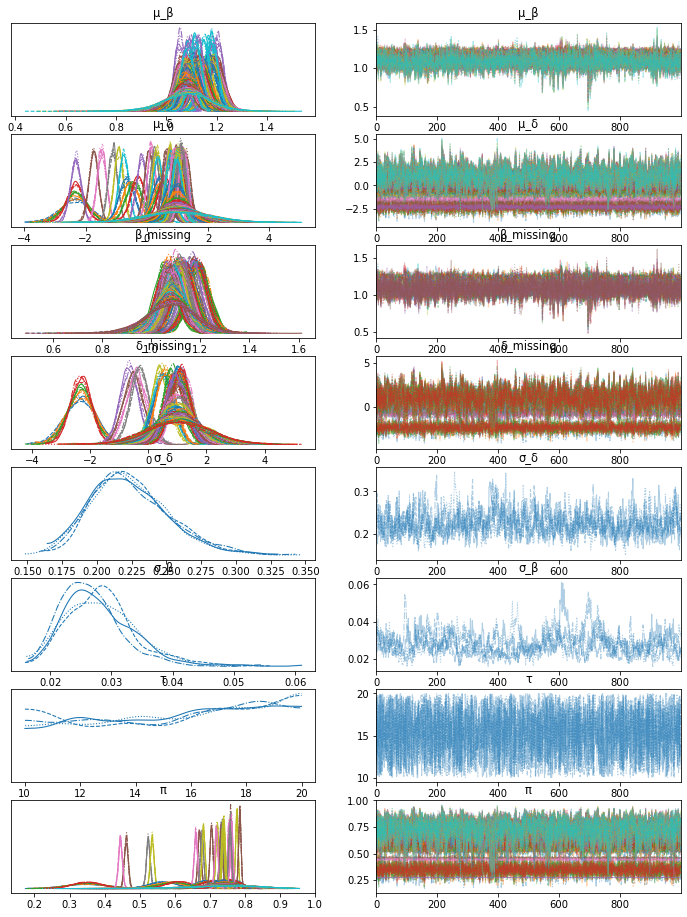

In [135]:
az.plot_trace(trace)

In [136]:
az.summary(trace)

/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_ch

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ_β[0],1.086,0.061,0.970,1.195,0.001,0.001,3415.0,2494.0,1.0
μ_β[1],1.086,0.055,0.984,1.188,0.001,0.001,3164.0,2307.0,1.0
μ_β[2],1.086,0.048,0.997,1.176,0.001,0.001,2901.0,2263.0,1.0
μ_β[3],1.087,0.039,1.014,1.159,0.001,0.001,3140.0,2441.0,1.0
μ_β[4],1.086,0.026,1.033,1.134,0.000,0.000,3510.0,2615.0,1.0
...,...,...,...,...,...,...,...,...,...
π[75],0.729,0.095,0.554,0.896,0.003,0.002,1059.0,1373.0,1.0
π[76],0.729,0.097,0.547,0.899,0.003,0.002,1066.0,1404.0,1.0
π[77],0.728,0.100,0.547,0.907,0.003,0.002,1098.0,1456.0,1.0
π[78],0.729,0.101,0.547,0.906,0.003,0.002,1127.0,1456.0,1.0


In [155]:
final_polls = trace.posterior['π'][:,:,-1]
final_polls

<xarray.DataArray 'π' (chain: 4, draw: 1000)>
array([[0.95939839, 0.79990641, 0.85992434, ..., 0.87507037, 0.00964209,
        0.26433415],
       [0.92601761, 0.97978313, 0.99777561, ..., 0.80222256, 0.92608655,
        0.41775215],
       [0.82882122, 0.93145409, 0.64019519, ..., 0.65383709, 0.57540118,
        0.9410256 ],
       [0.72107116, 0.92257013, 0.4176025 , ..., 0.4738109 , 0.30652422,
        0.45141084]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    π_dim_0  int64 79

In [146]:
(final_polls>.5).sum()/final_polls.size

<xarray.DataArray 'π' ()>
array(0.97575)
Coordinates:
    π_dim_0  int64 79